# Testing modular approach and master script for step integration

The idea is to integrate all my analysis in a single script.
The idea is to be tidy and consistent, andp rovide a sequential set of steps that would make anyone underastand what I did and how I reach my conclusiopns.
Eventually, this script could be uploaded in something like a git repository.

In [1]:
import US25UW990JEPL_02 as JEPL
import copy
t=1

In [2]:
init = JEPL.Initializer(data_path='/blue/mateescu/agustinchasco/Projects/reprojersey/data',
                        code_path='/blue/mateescu/agustinchasco/Projects/reprojersey/core',
                        testing=t)

init.Directories()
init.GetFormatMap()

Initialization: 

Code ipykernel_launcher.py starts. 
Codes executed when testing is 1. 
Running program in /blue/mateescu/agustinchasco/Projects/reprojersey/core. 
Reading data in /blue/mateescu/agustinchasco/Projects/reprojersey/data. 
Saving data in /blue/mateescu/agustinchasco/Projects/reprojersey/data. 
Time profiling starts. Program executed on 04-03-2025 at 09:38 PM EST.

Path `/blue/mateescu/agustinchasco/Projects/reprojersey/data/ipykernel_launcher/test` already exists. 

Path `/blue/mateescu/agustinchasco/Projects/reprojersey/data/view` already exists. 

Loading map ipykernel_launcher_test_f4map.json in pathf4_map_path: 
 /blue/mateescu/agustinchasco/Projects/reprojersey/data/ipykernel_launcher/test/ipykernel_launcher_test_f4map.json 
 

Loading map ipykernel_launcher_test_f5map.json in pathf5_map_path: 
 /blue/mateescu/agustinchasco/Projects/reprojersey/data/ipykernel_launcher/test/ipykernel_launcher_test_f5map.json 
 

Creation of master map ipykernel_launcher_test_fmap.jso

In [3]:
print(f'JEPL020101 activated when testing is {init.t}. \n')
fn = ['US25UW990JEPL.01_impl_010601pdfu.txt', 'US25UW990JEPL.01_test_010601pdfu.txt'][init.t]
fp = init.TargetPath(fn)

print(f'Loading file {fn} in path: \n {fp} \n \n')
dc = JEPL.DataContainer(init, pdfu = init.TXT_reader(target_path=fp))
dc.ShowDatasets()

JEPL020101 activated when testing is 1. 

Loading file US25UW990JEPL.01_test_010601pdfu.txt in path: 
 /blue/mateescu/agustinchasco/Projects/reprojersey/data/US25UW990JEPL.02/test/US25UW990JEPL.01_test_010601pdfu.txt 
 

init: <class 'US25UW990JEPL_02.Initializer'> (Not a DataFrame) 

pdfu: <class 'pandas.core.frame.DataFrame'> with shape (23353, 650) 



In [4]:
dc.SetKey(['pdfu'], [['f4X3', 'f4X4', 'f4X5', 'f4X35'], ['f5X3', 'f5X4', 'f5X5', 'f5X35']])

Setting key in merged dataset with 650 columns.


In [5]:
dc.pdfu['Key'][0:10]

0    JE               20120216
1    JE               20161013
2    JE               20210726
3    JE84000006726960620160505
4    JE84000006754087220151208
5    JE84000030025846120120726
6    JE84000300058695420100922
7    JE84000300095328920090828
8    JE84000300116779120100913
9    JE84000300122417820080202
Name: Key, dtype: object

In [7]:
import re

str1 = 'Type of reproductive event'
str2 = 'Date of reproductive event'
ks = [
    int(re.findall(r'X(\d+)', k1)[0])
    for k1 in dc.init.mapf
    for k2 in dc.init.mapf[k1]
    if (str1 in k2 or str2 in k2)
]

[37,
 38,
 52,
 53,
 67,
 68,
 82,
 83,
 97,
 98,
 112,
 113,
 127,
 128,
 142,
 143,
 157,
 158,
 172,
 173,
 187,
 188,
 202,
 203,
 217,
 218,
 232,
 233,
 247,
 248,
 262,
 263,
 277,
 278,
 292,
 293,
 307,
 308,
 322,
 323]

In [16]:
dc.GetSubset(dataset_name='pdfu', 
             colf4=None, 
             colf5=ks, 
             n=200,
             lact='m', 
             seed=2)

init: <class 'US25UW990JEPL_02.Initializer'> (Not a DataFrame) 

pdfu: <class 'pandas.core.frame.DataFrame'> with shape (23353, 651) 

sdf: <class 'pandas.core.frame.DataFrame'> with shape (204, 41) 

Saving View in: 
 /blue/mateescu/agustinchasco/Projects/reprojersey/core/ipykernel_launcher/test/ipykernel_launcher.html 
 



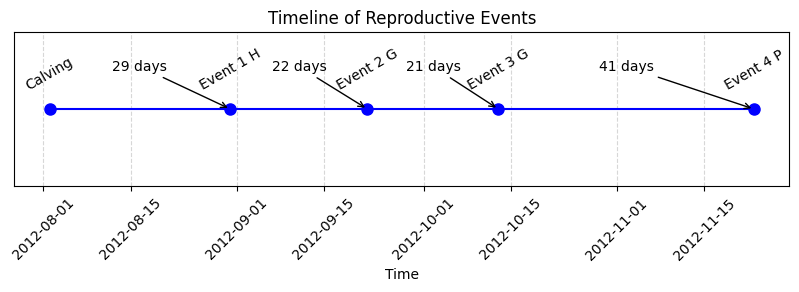

In [9]:
import matplotlib.pyplot as plt
import datetime

# Given data
dates = ["20120802", "20120831", "20120922", "20121013", "20121123"]
events = ["Calving", "Event 1 H", "Event 2 G", "Event 3 G", "Event 4 P"]

# Convert to datetime objects
dates = [datetime.datetime.strptime(date, "%Y%m%d") for date in dates]

# Calculate the differences between consecutive dates (in days)
date_differences = [(dates[i+1] - dates[i]).days for i in range(len(dates) - 1)]

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(dates, [1] * len(dates), "bo-", markersize=8)  # Blue dots with line

# Add event labels
for date, event in zip(dates, events):
    ax.text(date, 1.05, event, ha="center", fontsize=10, rotation=30)

# Add vertical lines and text to show the days between consecutive events
for i, diff in enumerate(date_differences):
    ax.annotate(f"{diff} days", 
                xy=(dates[i+1], 1), 
                xytext=(dates[i] + (dates[i+1] - dates[i])/2, 1.1),
                horizontalalignment='center', fontsize=10, rotation=0,
                arrowprops=dict(arrowstyle="->", lw=1))

# Formatting
ax.set_ylim(0.8, 1.2)
ax.set_yticks([])
ax.set_xlabel("Time")
ax.set_title("Timeline of Reproductive Events")
plt.xticks(rotation=45)
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()


# I need to extract time of labeled subsequent reproductive events.

In [15]:
dc.sdf.head()

,f4X3,f4X4,f4X5,f4X35,f4X43,f5X37,f5X38,f5X52,f5X53,f5X67,...,f5X263,f5X277,f5X278,f5X292,f5X293,f5X307,f5X308,f5X322,f5X323,Key
0,JE,840,003001860463,20110112,03,A,20110304,P,20110414,,...,,,,,,,,,,JE84000300186046320110112
1,JE,840,003001930427,20051009,01,H,20051023,A,20060107,P,...,,,,,,,,,,JE84000300193042720051009
2,JE,840,003004634932,20121005,01,A,20121205,A,20121229,P,...,,,,,,,,,,JE84000300463493220121005
3,JE,840,003004640446,20120629,01,A,20121005,P,20121115,,...,,,,,,,,,,JE84000300464044620120629
4,JE,840,003008237417,20141216,03,G,20150221,O,20150326,G,...,,,,,,,,,,JE84000300823741720141216


In [14]:
keys = dc.ColSelect(f4=None, f5=ks, key='Key')
df = dc.sdf[keys]
df.head()

,Key,f5X37,f5X38,f5X52,f5X53,f5X67,f5X68,f5X82,f5X83,f5X97,...,f5X262,f5X263,f5X277,f5X278,f5X292,f5X293,f5X307,f5X308,f5X322,f5X323
0,JE84000300126449120120129,A,20120425,P,20120706,,,,,,...,,,,,,,,,,
1,JE84000300192764020080110,H,20080120,A,20080228,P,20080423,,,,...,,,,,,,,,,
2,JE84000300392602920110811,H,20110916,A,20110930,A,20111021,O,20111208,N,...,,,,,,,,,,
3,JE84000300411264920221231,G,20230316,P,20230417,,,,,,...,,,,,,,,,,
4,JE84000300459177820120302,A,20120604,P,20120712,,,,,,...,,,,,,,,,,


In [28]:
str1 = 'Type of reproductive event'
k1 = [
    int(re.findall(r'X(\d+)', k1)[0])
    for k1 in dc.init.mapf
    for k2 in dc.init.mapf[k1]
    if (str1 in k2)
]

str2 = 'Date of reproductive event'
k2 = [
    int(re.findall(r'X(\d+)', k1)[0])
    for k1 in dc.init.mapf
    for k2 in dc.init.mapf[k1]
    if (str2 in k2)
]

tk = dc.ColSelect(f4=None, f5=k1, key=None)
dk = dc.ColSelect(f4=None, f5=k2, key=None)

In [37]:
for j in range(len(tk)):
    print(df[tk[j]])

0      A
1      H
2      H
3      G
4      A
      ..
199    n
200    A
201    A
202    A
203    A
Name: f5X37, Length: 204, dtype: object
0      P
1      A
2      A
3      P
4      P
      ..
199    n
200    A
201    A
202    A
203    A
Name: f5X52, Length: 204, dtype: object
0       
1      P
2      A
3       
4       
      ..
199    n
200    A
201    A
202    A
203    A
Name: f5X67, Length: 204, dtype: object
0       
1       
2      O
3       
4       
      ..
199    n
200    O
201    A
202    P
203    A
Name: f5X82, Length: 204, dtype: object
0       
1       
2      N
3       
4       
      ..
199    n
200    A
201    P
202     
203    A
Name: f5X97, Length: 204, dtype: object
0       
1       
2      A
3       
4       
      ..
199    n
200    P
201     
202     
203    A
Name: f5X112, Length: 204, dtype: object
0       
1       
2      A
3       
4       
      ..
199    n
200     
201     
202     
203    P
Name: f5X127, Length: 204, dtype: object
0       
1       
2      

,f5X37,f5X52,f5X67,f5X82,f5X97,f5X112,f5X127,f5X142,f5X157,f5X172,f5X187,f5X202,f5X217,f5X232,f5X247,f5X262,f5X277,f5X292,f5X307,f5X322
0,A,P,,,,,,,,,,,,,,,,,,
1,H,A,P,,,,,,,,,,,,,,,,,
2,H,A,A,O,N,A,A,P,,,,,,,,,,,,
3,G,P,,,,,,,,,,,,,,,,,,
4,A,P,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n
200,A,A,A,O,A,P,,,,,,,,,,,,,,
201,A,A,A,A,P,,,,,,,,,,,,,,,
202,A,A,A,P,,,,,,,,,,,,,,,,
